In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
%matplotlib inline

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../../../'
sys.path.insert(0,path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

# MAVE-NN utilities
from mavenn.src.dev import mutations_to_dataset

['../../../../mavenn']


In [2]:
# Save data_df
file_name = '../ace2rbd_data.csv.gz'
data_df = pd.read_csv(file_name, compression='gzip')

In [3]:
# Split into training and test sets
ix = data_df['training_set']
training_df = data_df[ix].copy()
test_df = data_df[~ix].copy()

In [4]:
# Set seeed
mavenn.set_seed(0)

# Define additive model
model = mavenn.Model(x=training_df['x'].values,
                     y=training_df['y'].values,
                     alphabet='protein',
                     gpmap_type='additive',
                     regression_type='GE',
                     ge_noise_model_type='Cauchy',
                     ge_heteroskedasticity_order=2)

# Fit additive model
start_time = time.time()
history = model.fit(epochs=1000, 
                    early_stopping=True, 
                    early_stopping_patience=20,
                    learning_rate=.0005, 
                    batch_size=50)
training_time = time.time()-start_time
print(f'training time: {training_time:.1f} seconds')

Epoch 1/1000
1874/1874 [==============================] - 4s 2ms/step - loss: 127.9820 - val_loss: 140.6906
Epoch 2/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 121.0415 - val_loss: 135.1223
Epoch 3/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 120.6955 - val_loss: 133.8581
Epoch 4/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 120.6674 - val_loss: 133.4317
Epoch 5/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 120.6582 - val_loss: 133.8257
Epoch 6/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 120.6573 - val_loss: 133.1633
Epoch 7/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 120.6511 - val_loss: 133.6028
Epoch 8/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 120.6524 - val_loss: 133.6766
Epoch 9/1000
1874/1874 [==============================] - 3s 2ms/step - loss: 120.6212 - val_loss: 133.2470
Epoch 10/1000
1874/1874 [===

1874/1874 [==============================] - 3s 2ms/step - loss: -4.3031 - val_loss: 18.0201
Epoch 78/1000
1874/1874 [==============================] - 3s 2ms/step - loss: -4.1148 - val_loss: 20.2413
Epoch 79/1000
1874/1874 [==============================] - 3s 2ms/step - loss: -4.3023 - val_loss: 20.4546
Epoch 80/1000
1874/1874 [==============================] - 3s 2ms/step - loss: -4.8824 - val_loss: 20.8932
Epoch 81/1000
1874/1874 [==============================] - 3s 2ms/step - loss: -4.9944 - val_loss: 21.7081
Epoch 82/1000
1874/1874 [==============================] - 3s 2ms/step - loss: -4.4934 - val_loss: 22.1642
Epoch 83/1000
1874/1874 [==============================] - 3s 2ms/step - loss: -5.0504 - val_loss: 18.9935
Epoch 84/1000
1874/1874 [==============================] - 3s 2ms/step - loss: -4.9230 - val_loss: 22.6488
Epoch 85/1000
1874/1874 [==============================] - 4s 2ms/step - loss: -4.9853 - val_loss: 22.3302
Epoch 86/1000
1874/1874 [==========================

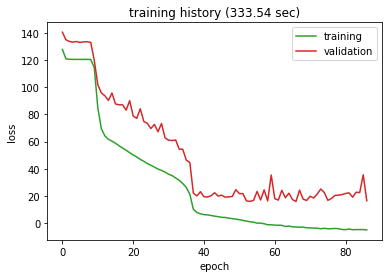

In [5]:
# Extract training loss and validation loss
history_dict = history.history
loss_training = history_dict['loss']
loss_validation = history_dict['val_loss']

# Plot model training history
fig, ax = plt.subplots()
ax.plot(loss_training, color='C2', label='training')
ax.plot(loss_validation, color='C3', label='validation')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title(f"training history ({training_time:.2f} sec)")
ax.legend()

In [6]:
# Determine wild-type sequence
wt_seq = mavenn.x_to_consensus(training_df['x'])
wt_seq

'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'

In [7]:
# Get mask, if any. Will show which amino acids were not assayed
mask_dict = mavenn.get_mask_dict(training_df['x'], alphabet='protein')
mask_dict

{19: 'F', 66: 'EKMQW', 192: 'CEHKMQW', 193: 'CEFHKMNQS'}

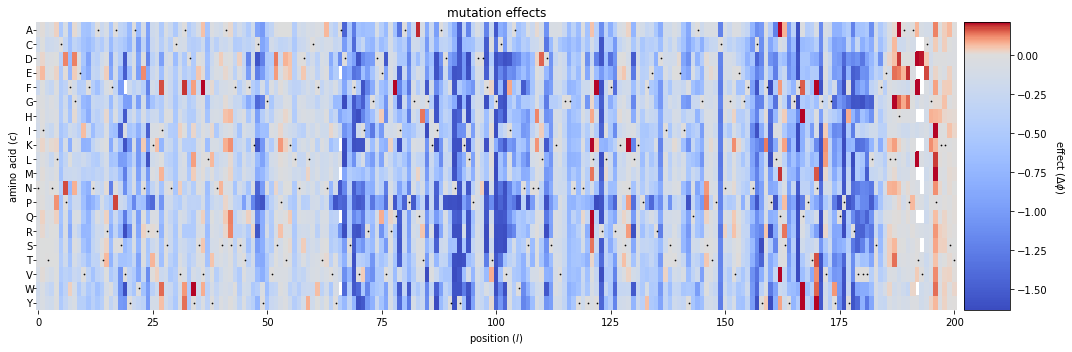

In [8]:
# Get effects of all single-point mutations on phi
dphi_df = mavenn.get_1pt_effects(func=model.x_to_phi,
                                 wt_seq=wt_seq,
                                 alphabet='protein')
# Draw heatmap
fig, ax = plt.subplots(figsize=[15,5])
ax, cb = mavenn.heatmap(dphi_df,
                        ccenter=0,
                        clim_quantile=.99,
                        mask_dict=mask_dict,
                        missing_values=0,
                        c_col='c_mut',
                        l_col='l',
                        value_col='dphi',
                        seq=wt_seq,
                        #cmap='PiYG',
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax.set_title('mutation effects')
fig.tight_layout()
fig.savefig('ace2rbd.pdf')

In [9]:
N = len(test_df['x'].values)
ix = np.random.rand(N) < .5

# Extract data into np.arrays
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.05,.95])

Text(0.5, 1.0, 'measurement process')

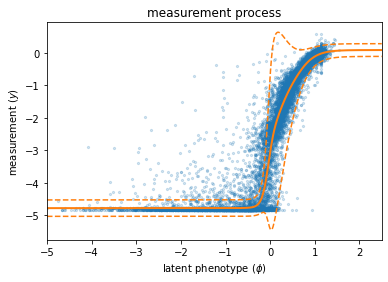

In [10]:
fig, ax = plt.subplots()

ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')

In [11]:
# Save model
model.save('ace2rbd_model')

Model saved to these files:
	ace2rbd_model.pickle
	ace2rbd_model.h5
